# Personal Information
Name: **Yanchao MURONG**

StudentID: **14090759**

Email: [**yanchao.murong@student.uva.nl**](yanchao.murong@student.uva.nl)

Submitted on: **25.03.2024**

# Purpose
The purpose of this EDA is to compare the synthetic questions generated by T5 language model with real human questions under legal context from a syntactic structure perspective. 

# Why
During my preliminary experimentation in the domain of statutory legal information retrieval, we find that GPL (Generative Pseudo Labeling) perform slightly better than zero-shot model such as BM25 (MRR@100: 27.99 vs 24.45) but not significantly. It is also true in other domains according to the benchmark provided by the original GPL paper. As generation based domain adaptation technique such as GPL heavily relies on generated synthetic queries, we assume syntactic insights from generated queries can help us locate improvement opportunities.

# Dataset
BSARD Dataset Human Questions (dfQ_human):

The Belgian Statutory Article Retrieval Dataset (BSARD) is a dataset created for the task of statutory article retrieval (SAR). The corpus consisted of 22,633 law articles extracted from 32 publicly available Belgian codes. The questions were collected from Droits Quotidiens, an organization that clarifies the law for laypeople, and were carefully labeled with the ids of the corresponding relevant law articles from the corpus. The dataset was split into training/test sets with 886 and 222 questions, respectively. The dataset has a wide range of legal topics, with around 85% of the questions being about family, housing, money, or justice. The questions might have one or several relevant legal articles, and 75% of the questions have less than five relevant articles. Overall, out of the 22,633 articles, only 1612 are referred to as relevant to at least one question in the dataset, and around 80% of these articles come from either the Civil Code, Judicial Code, Criminal Investigation Code, or Penal Code.

Synthetic Dataset 1 (dfQ_syn1):
Synthetic questions data generated by the model mT5 (doc2query/msmarco-french-mt5-base-v1). We have generated 1 question for each legal article from BSARD Dataset (due to our computation limit). 

Synthetic Dataset 2 (dfQ_syn2):
Synthetic questions data generated by the author of BSARD Dataset. 5 question for each legal article from BSARD Dataset are generated. 

Dataset MS Marco Human Questions (dfQ_mmarco):
Queries from the MS MARCO dataset which features real Bing questions and a human generated answer translated in French. Many languages models are fine tuned based on MS MARCO dataset such as the one we used doc2query/msmarco-french-mt5-base-v1.


# Data Description


In [110]:
# Imports
import numpy as np
import pandas as pd
from parallel_pandas import ParallelPandas
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
ParallelPandas.initialize(disable_pr_bar=False)
tqdm.pandas(desc='Processing text')
nlp = spacy.load("fr_core_news_sm")

### Data Loading

In [176]:
# Load your data here
dfQ_train = pd.read_csv("./data/questions_fr_train.csv")
dfQ_test = pd.read_csv("./data/questions_fr_test.csv")

dfQ_human = pd.concat([dfQ_train, dfQ_test])
dfQ_syn1 = pd.read_json("./data/qgen-queries.jsonl", lines=True)
dfQ_syn2 = pd.read_csv("./data/questions_synthetic.csv")

dfQ_mmarco = pd.read_csv("./data/mmarco/french_queries.train.tsv", sep='\t', header=None, names=["id", "question"])

dfQ_syn_openai_generate_only = pd.read_json("./data/gpt4_generate_only_openai.jsonl", lines=True)
dfQ_syn_openai_question_type = pd.read_json("./data/gpt4_generate_question_type_openai.jsonl", lines=True)

### Analysis 1: Number of Questions

In [3]:
# Count the number of questions in each DataFrame
counts = [len(df) for df in [dfQ_human, dfQ_syn1, dfQ_syn2]]

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'DataFrame': ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2'],
    'Number of Questions': counts
})
summary_df

,DataFrame,Number of Questions
0,dfQ_human,1108
1,dfQ_syn1,22633
2,dfQ_syn2,113165


([0, 1, 2],
 [Text(0, 0, 'dfQ_human'), Text(1, 0, 'dfQ_syn1'), Text(2, 0, 'dfQ_syn2')])

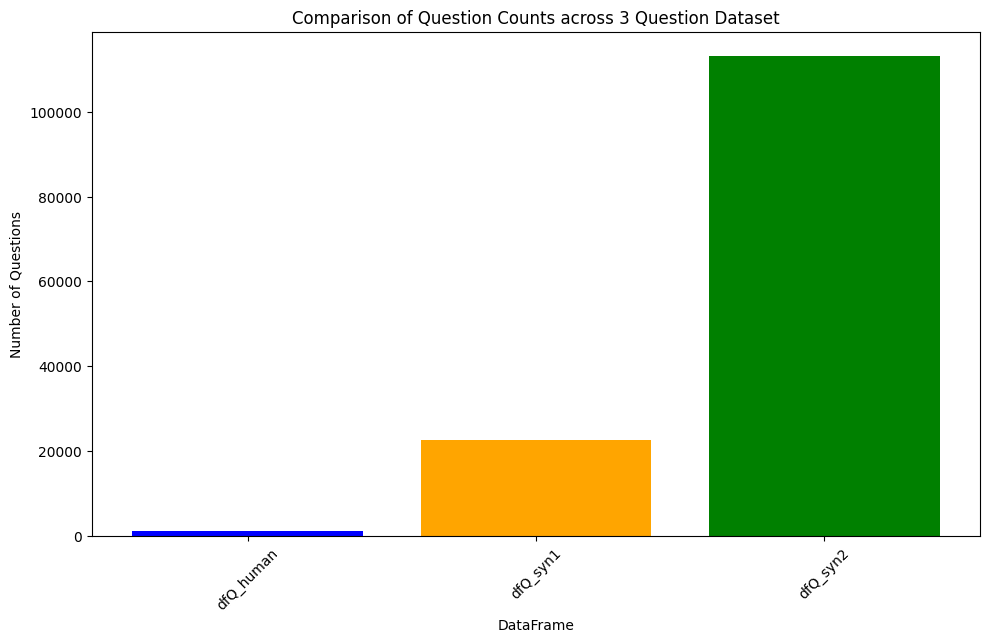

In [4]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(summary_df['DataFrame'], summary_df['Number of Questions'], color=['blue', 'orange', 'green'])
plt.title('Comparison of Question Counts across 3 Question Dataset')
plt.xlabel('DataFrame')
plt.ylabel('Number of Questions')
plt.tight_layout()
plt.savefig('Comparison of Question Counts across 3 Question Dataset.pdf')
plt.xticks(rotation=45)

We can see that human questions are far less than synthetic questions. 

### Analysis 2: Question Length

In [163]:
# Calculate the length of each question
dfQ_human['Length'] = dfQ_human['question'].apply(len)
dfQ_syn1['Length'] = dfQ_syn1['text'].apply(len)
dfQ_syn2['Length'] = dfQ_syn2['question'].apply(len)
dfQ_mmarco['Length'] = dfQ_mmarco['question'].apply(len)

# Compute the average length of questions in each DataFrame
avg_lengths = [df['Length'].mean() for df in [dfQ_human, dfQ_syn1, dfQ_syn2, dfQ_mmarco]]

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'DataFrame': ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco'],
    'Average Question Length': avg_lengths
})

summary_df

,DataFrame,Average Question Length
0,dfQ_human,88.252708
1,dfQ_syn1,54.395308
2,dfQ_syn2,54.762665
3,dfQ_mmarco,43.806178


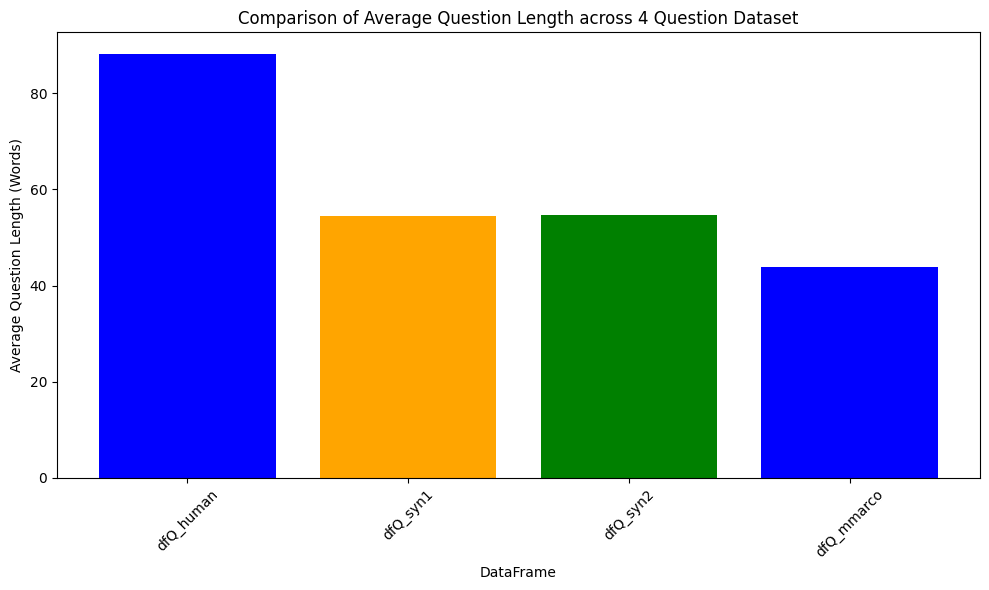

In [165]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(summary_df['DataFrame'], summary_df['Average Question Length'], color=['blue', 'orange', 'green'])
plt.title('Comparison of Average Question Length across 4 Question Dataset')
plt.xlabel('DataFrame')
plt.ylabel('Average Question Length (Words)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Comparison of Average Question Length across DataFrames.pdf')
plt.show()

In average, legal human questions are much longer than synthetic questions and mmarco human queries. 

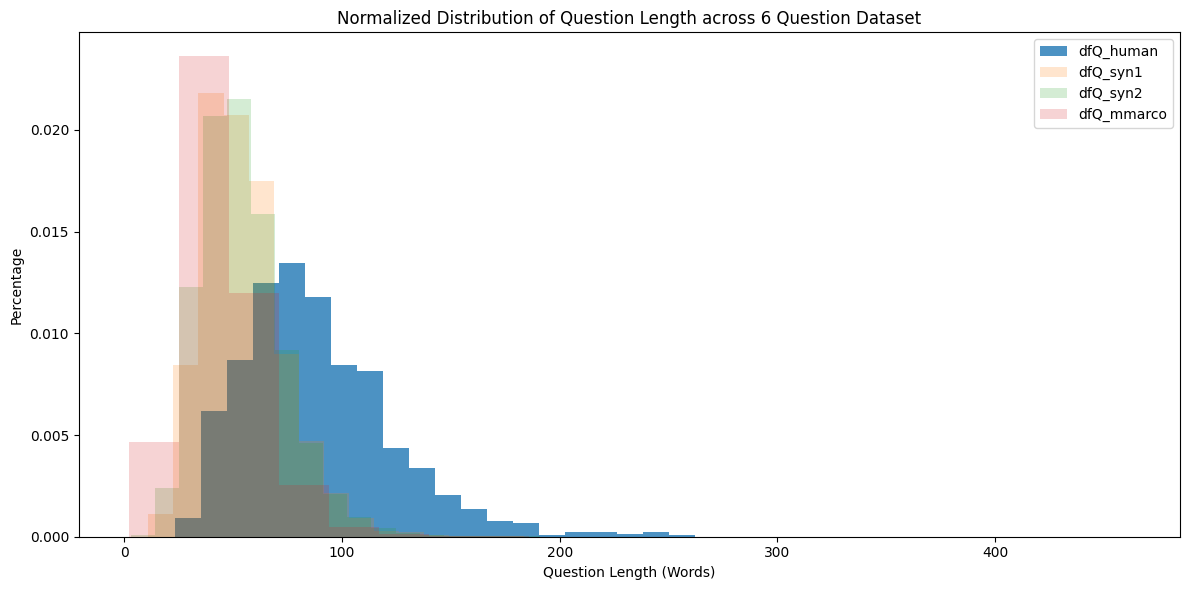

In [160]:
# Plotting
plt.figure(figsize=(12, 6))

# Histograms for each DataFrame
plt.hist(dfQ_human['Length'], alpha=0.8, label='dfQ_human', bins=20, density=True)
plt.hist(dfQ_syn1['Length'], alpha=0.2, label='dfQ_syn1', bins=20, density=True)
plt.hist(dfQ_syn2['Length'], alpha=0.2, label='dfQ_syn2', bins=20, density=True)
plt.hist(dfQ_mmarco['Length'], alpha=0.2, label='dfQ_mmarco', bins=20, density=True)

plt.title('Normalized Distribution of Question Length across 6 Question Dataset')
plt.xlabel('Question Length (Words)')
plt.ylabel('Percentage')
plt.legend()
plt.tight_layout()
plt.savefig('Normalized Distribution of Question Lengths.pdf')
plt.show()

Normalized distribution have demonstrated the same conclusion: In legal domain, people tend to ask longer question. 

### Analysis 3: Number of Sentences in Question


In [12]:
class TextPreprocessor():
    def __init__(self, spacy_model="fr_core_news_sm"):
        self.nlp = spacy.load(spacy_model)

    def preprocess(self, series, sentences=False):
        return (series.progress_apply(
            lambda text: self.preprocess_text(text, sentences)))

    def preprocess_text(self, text, split_sentences):
        doc = self.nlp(text)
        if split_sentences:
            return list(doc.sents)
        else:
            text = self._get_text(doc)
        return text

    def _get_text(self, doc):
        return ' '.join([t.text for t in doc])


processor = TextPreprocessor()

dfQ_human['NB_SENTENCES'] = processor.preprocess(dfQ_human["question"], sentences=True).apply(len)
dfQ_syn1['NB_SENTENCES'] = processor.preprocess(dfQ_syn1["text"], sentences=True).apply(len)
dfQ_syn2['NB_SENTENCES'] = processor.preprocess(dfQ_syn2["question"], sentences=True).apply(len)


Processing text: 100%|██████████| 113165/113165 [06:04<00:00, 310.05it/s]


In [45]:
dfQ_mmarco['NB_SENTENCES'] = processor.preprocess(dfQ_mmarco["question"].sample(10000), sentences=True).apply(len)

Processing text: 100%|██████████| 10000/10000 [00:30<00:00, 322.65it/s]


In [46]:
# Compute the average length of questions in each DataFrame
avg_lengths = [df['NB_SENTENCES'].mean() for df in [dfQ_human, dfQ_syn1, dfQ_syn2, dfQ_mmarco]]

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'DataFrame': ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco'],
    'Average Number of Sentences in Question': avg_lengths
})

summary_df

,DataFrame,Average Number of Sentences in Question
0,dfQ_human,1.618231
1,dfQ_syn1,1.048867
2,dfQ_syn2,1.051562
3,dfQ_mmarco,1.134600


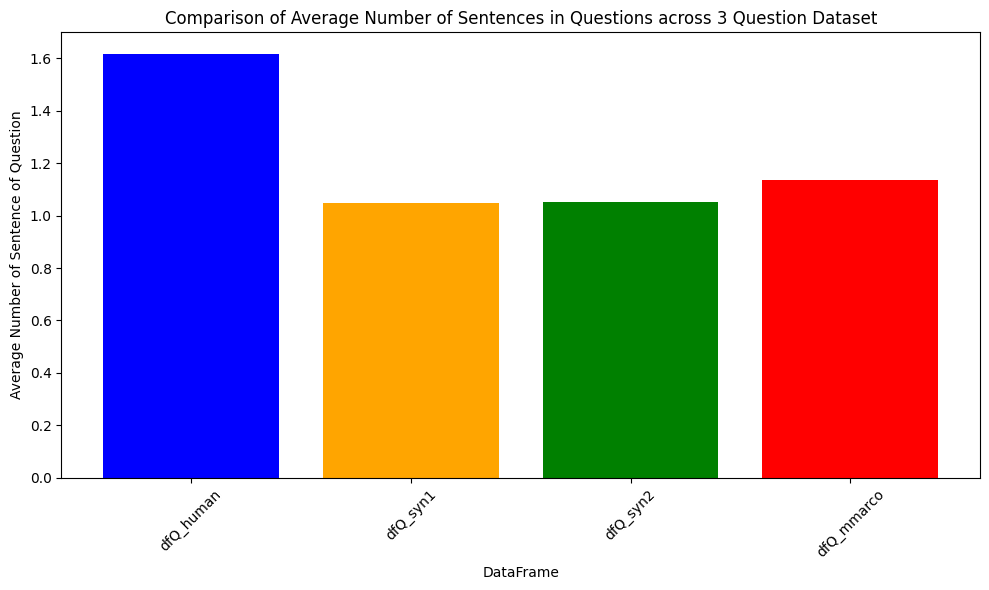

In [47]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(summary_df['DataFrame'], summary_df['Average Number of Sentences in Question'],
        color=['blue', 'orange', 'green', 'red'])
plt.title('Comparison of Average Number of Sentences in Questions across 3 Question Dataset')
plt.xlabel('DataFrame')
plt.ylabel('Average Number of Sentence of Question')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Comparison of Average Number of Sentence of Question across DataFrames.pdf')
plt.show()

We find that legal human question tends to be composed by more than one sentence. That partially explains why legal human question are longer the the other questions.

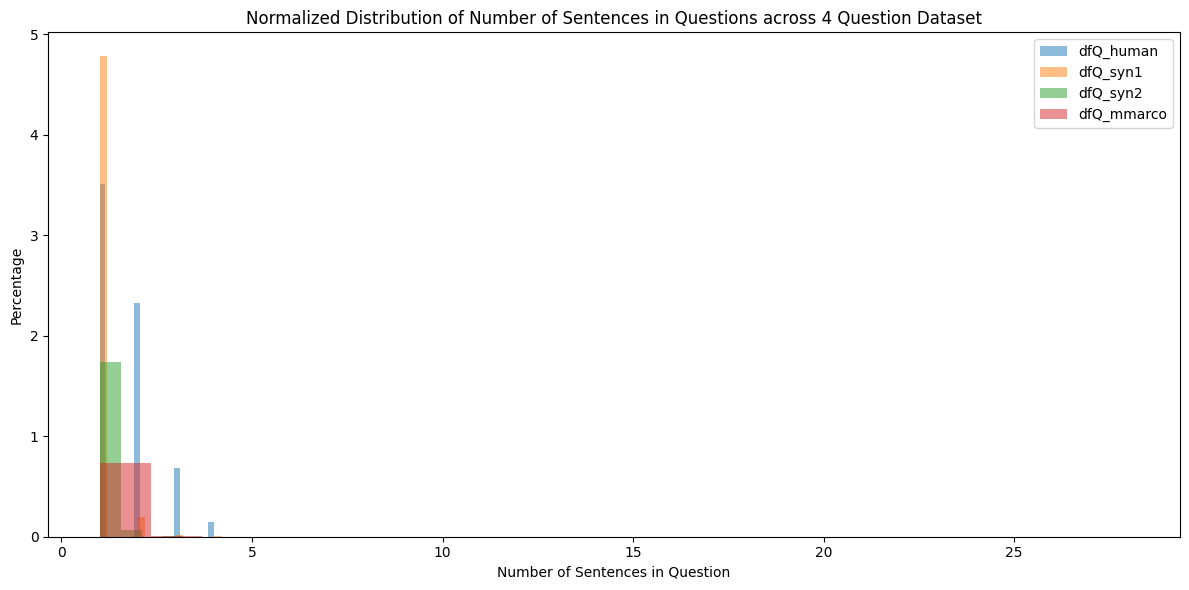

In [48]:
# Plotting
plt.figure(figsize=(12, 6))

# Histograms for each DataFrame
plt.hist(dfQ_human['NB_SENTENCES'], alpha=0.5, label='dfQ_human', bins=20, density=True)
plt.hist(dfQ_syn1['NB_SENTENCES'], alpha=0.5, label='dfQ_syn1', bins=20, density=True)
plt.hist(dfQ_syn2['NB_SENTENCES'], alpha=0.5, label='dfQ_syn2', bins=20, density=True)
plt.hist(dfQ_mmarco['NB_SENTENCES'], alpha=0.5, label='dfQ_mmarco', bins=20, density=True)

plt.title('Normalized Distribution of Number of Sentences in Questions across 4 Question Dataset')
plt.xlabel('Number of Sentences in Question')
plt.ylabel('Percentage')
plt.legend()
plt.tight_layout()
plt.savefig('Normalized Distribution of Number of Sentences in Question.pdf')
plt.show()

Normalized distribution figure show that legal human question can be composed of 2 or more sentences while synthetic questions are usually composed by 1 sentence.

After verifying some legal questions that have more than 2 sentences, the reason under the hood is also quite straightforward to understand: why people ask a legal question, they tend to describe their situation and then ask the question. Hence, one legal question is usually composed of a declarative phrase and an interrogative phrase.

### Analysis 4: Pos Tagging Distribution

In [16]:
# Function to count POS tags in a dataset
def count_pos_tags(series):
    tag_counts = {}
    for question in series:
        doc = nlp(question)
        for token in doc:
            tag = token.pos_
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    total_tags = sum(tag_counts.values())
    # Normalize counts to get density
    tag_counts = {tag: count / total_tags for tag, count in tag_counts.items()}
    return tag_counts

In [17]:
dfQ_human_pos_dist = count_pos_tags(dfQ_human["question"])
dfQ_syn1_pos_dist = count_pos_tags(dfQ_syn1["text"])
dfQ_syn2_pos_dist = count_pos_tags(dfQ_syn2["question"])

In [18]:
dfQ_mmarco_pos_dist = count_pos_tags(dfQ_mmarco["question"].sample(10000))

In [167]:
dfQ_syn_openai_generate_only_pos_dist = count_pos_tags(dfQ_syn_openai_generate_only["synthetic_question"].sample(5000))
dfQ_syn_openai_question_type_pos_dist = count_pos_tags(dfQ_syn_openai_question_type["synthetic_question"].sample(5000))

In [169]:
tag_counts_datasets = [dfQ_human_pos_dist, dfQ_syn1_pos_dist, dfQ_syn2_pos_dist, dfQ_mmarco_pos_dist,dfQ_syn_openai_generate_only_pos_dist, dfQ_syn_openai_question_type_pos_dist]
# Convert to DataFrame for easier plotting
df_tags = pd.DataFrame(tag_counts_datasets).T
df_tags.columns = ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco', 'dfQ_syn_openai_generate_only', 'dfQ_syn_openai_question_type']
df_tags = df_tags.fillna(0)  # Fill missing values with 0
df_tags

,dfQ_human,dfQ_syn1,dfQ_syn2,dfQ_mmarco,dfQ_syn_openai_generate_only,dfQ_syn_openai_question_type
PRON,0.116705,0.072453,8.325543e-02,0.089491,0.023156,0.044792
AUX,0.041390,0.067481,6.253351e-02,0.058349,0.041204,0.032538
ADJ,0.058172,0.084133,7.295272e-02,0.091868,0.081793,0.065036
PROPN,0.025637,0.005653,3.892074e-03,0.019974,0.004531,0.005348
PUNCT,0.105380,0.008878,8.606982e-03,0.012741,0.050698,0.049896
CCONJ,0.019408,0.008112,6.217670e-03,0.007710,0.020165,0.018161
VERB,0.117786,0.069744,8.279123e-02,0.087303,0.094437,0.101688
ADP,0.135753,0.179172,1.779086e-01,0.155097,0.212409,0.196942
DET,0.117992,0.172053,1.652429e-01,0.145047,0.167744,0.160133
NOUN,0.194698,0.281459,2.805816e-01,0.262700,0.272321,0.270937


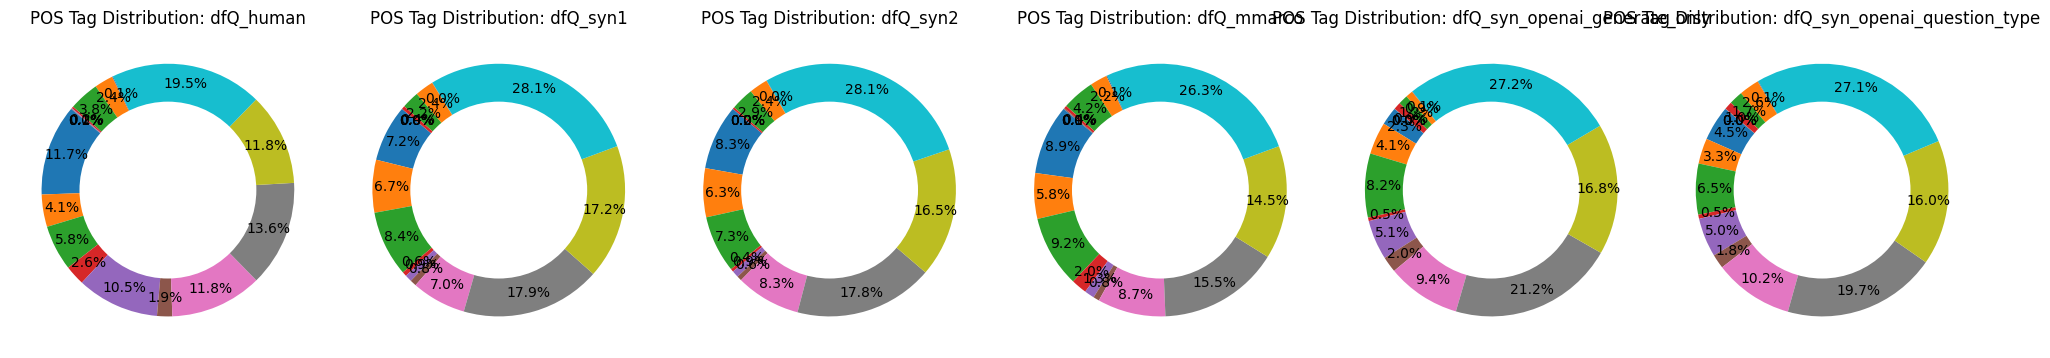

In [171]:
# Function to plot pie chart for each dataset
def plot_pie_chart(data, title, ax):
    data.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=140, pctdistance=0.85, labels=None)
    ax.set_ylabel('')  # Remove the y-label as it's not needed for pie charts
    ax.set_title(title)
    # Draw a circle at the center to make it a donut chart
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)


# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 6, figsize=(20, 7))

# Plotting pie charts for each dataset
for i, column in enumerate(df_tags.columns):
    plot_pie_chart(df_tags[column], f'POS Tag Distribution: {column}', axes[i])

plt.tight_layout()
plt.savefig('POS Tag Distribution.pdf')
plt.show()

We find that legal human questions are significantly different in terms of grammatical structure (Left 2 pie charts vs Right 3 pie charts). Interestingly, MS Marco human queries show a similar grammatical structure to synthetic legal questions. This might be due to the fact that the synthetic questions are generated by Doc2Query model that is fined tuned by MS MARCO query dataset. 

Note: As legal human question are usually composed of a declarative phrase and an interrogative phrase, we have extracted the interrogative part (dfQ_human_pure_question) so that we can also be able to compare the pure interrogative phrases. It is shown that the pure interrogative part also demonstrate significant differences comparing to synthetic legal questions and msmarco queries.

In [25]:
# Extract Interrogative phrase from human questions
dfQ_human_sentences = processor.preprocess(dfQ_human["question"], sentences=True)
dfQ_human_questions = dfQ_human_sentences.apply(
    lambda text: [sent.text.lower() for sent in text if "?" in sent.text.lower()][0]
)
dfQ_human_pure_question_pos_dist = count_pos_tags(dfQ_human_questions)

Processing text: 100%|██████████| 1108/1108 [00:03<00:00, 300.77it/s]


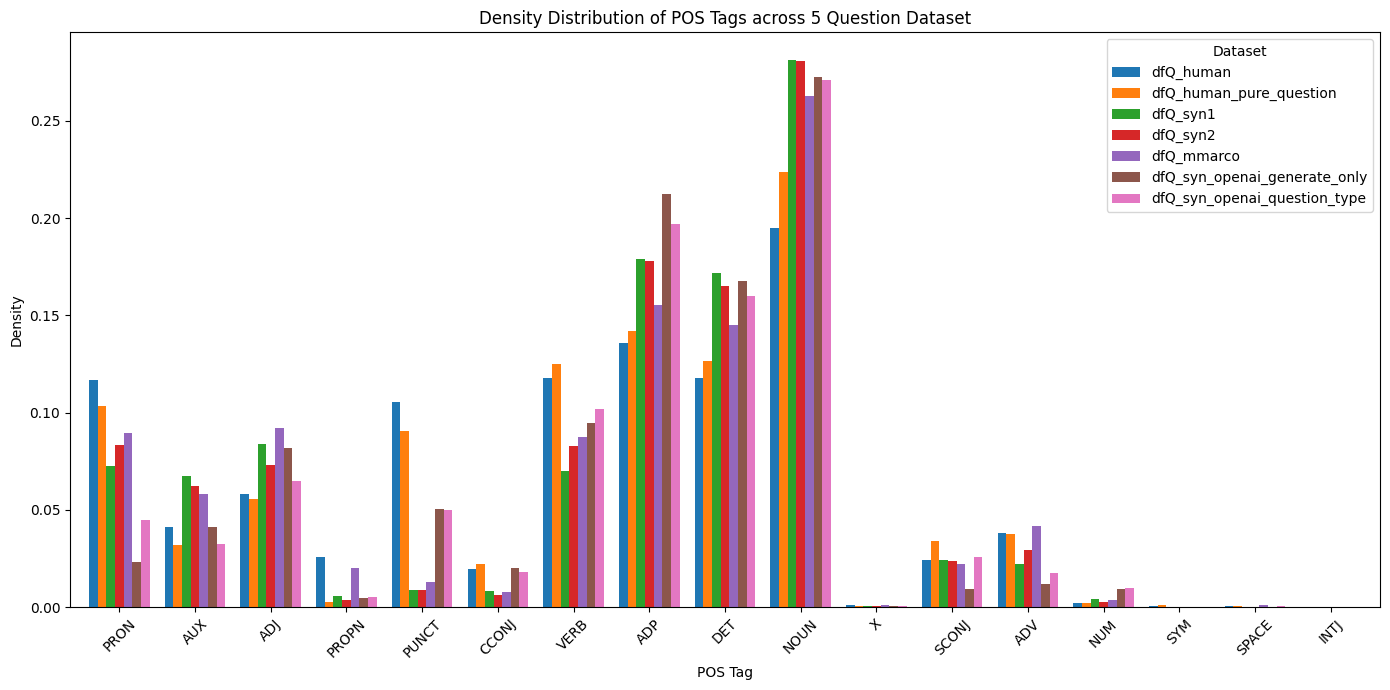

In [173]:
tag_counts_datasets = [dfQ_human_pos_dist, dfQ_human_pure_question_pos_dist, dfQ_syn1_pos_dist, dfQ_syn2_pos_dist, dfQ_mmarco_pos_dist, dfQ_syn_openai_generate_only, dfQ_syn_openai_question_type]
# Convert to DataFrame for easier plotting
df_tags = pd.DataFrame(tag_counts_datasets).T
df_tags.columns = ['dfQ_human', 'dfQ_human_pure_question', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco', 'dfQ_syn_openai_generate_only', 'dfQ_syn_openai_question_type']
df_tags = df_tags.fillna(0)  # Fill missing values with 0

# Plot the density distribution of POS tags
df_tags.plot(kind='bar', figsize=(14, 7), width=0.8)
plt.title('Density Distribution of POS Tags across 5 Question Dataset')
plt.xlabel('POS Tag')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('Density Distribution of POS Tags Across Datasets.pdf')
plt.show()

Specifically, legal human questions have less Nouns, ADP(adposition), DET(determiner), ADJ(adjective) and AUX (auxiliary). 
However, they have more verbs and prons (proper noun).

Note, legal human questions have more punctuations only because synthetic questions do not have question marks in the end. Hence, there is no significant difference in terms of punctuations in reality.

### Analysis 5: Question Categories
* Yes/No
* What
* Which
* Where
* Why
* How

In [29]:
# Extract Interrogative phrase from human questions
dfQ_human_sentences = processor.preprocess(dfQ_human["question"], sentences=True)
dfQ_human_questions = dfQ_human_sentences.apply(
    lambda text: [sent.text.lower() for sent in text if "?" in sent.text.lower()][0]
)
dfQ_human_questions

Processing text: 100%|██████████| 1108/1108 [00:03<00:00, 299.69it/s]


0      puis-je refuser de faire des heures supplément...
1                      peut-on saisir tous mes revenus ?
2                       dois-je reconnaître mon enfant ?
3      pour quels logements le permis de location est...
4      suis-je payé pendant la procédure du trajet de...
                             ...                        
217    dois-je payer les dettes de mon cohabitant lég...
218                       a qui dois-je payer ma dette ?
219                          qui doit payer les loyers ?
220    est-ce que je peux signer plusieurs baux de co...
221    en tant que victime de violences conjugales, p...
Name: question, Length: 1108, dtype: object

In [32]:
def categorize_question(question):
    def is_yes_no_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'suis-je', 'es-tu', 'est-il', 'sommes-nous', 'êtes-vous', 'sont-ils', 'sont-elles', 'est-elle',  # Être
            'ai-je', 'as-tu', 'a-t-il', 'avons-nous', 'avez-vous', 'ont-ils', 'ont-elles', 'a-t-on',  # Avoir
            'peux-tu', 'peut-il', 'pouvons-nous', 'pouvez-vous', 'peuvent-ils', 'puis-je', 'peut-on', 'peut-elle',
            # Pouvoir
            'dois-je', 'doit-il', 'devons-nous', 'devez-vous', 'doivent-ils', 'doit-on',  # Devoir
            'vais-je', 'vas-tu', 'va-t-il', 'allons-nous', 'allez-vous', 'vont-ils', 'va-t-on',  # Aller (future)
            'est-ce', 'faut-il', 't-il', 'est un', 'est une', 'est le', 'est la',
        ]

        return any(starter in question for starter in question_starters)

    def is_what_which_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'que f', 'que d', 'que s', 'que c', 'que v', 'qu\'est', 'quels ', 'quelles ', 'quelle ', 'quel ',
            'combien ',
            'à quoi', 'c\'est quoi', 'de quoi'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_when_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'quand', 'quel moment'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_where_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'où'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_how_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'comment'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_who_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'qui '
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_why_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'pourquoi'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    # Lowercase the question for standardization
    question = question.lower()

    if is_why_question(question):
        return "why"

    if is_how_question(question):
        return "how"

    if is_where_question(question):
        return "where"

    if is_when_question(question):
        return "when"

    if is_who_question(question):
        return "who"

    if is_what_which_question(question):
        # with open("what_questions.txt", "a") as f:
        #     f.write(question + "\n")
        return "what/which"

    if is_yes_no_question(question):
        # with open("yes_no_questions.txt", "a") as f:
        #     f.write(question + "\n")
        return "yes/no"

    with open("unknown_questions.txt", "a", encoding="utf-8") as f:
        f.write(question + "\n")

    return 'unknown'

In [33]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_human_questions_cat = dfQ_human_questions.p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/1108 [00:00<?, ?it/s]

In [34]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_syn1_questions_cat = dfQ_syn1["text"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/22633 [00:00<?, ?it/s]

In [35]:
dfQ_mmarco.columns

Index(['id', 'question'], dtype='object')

In [36]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_syn2_questions_cat = dfQ_syn2["question"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/113165 [00:00<?, ?it/s]

In [37]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_mmarco_questions_cat = dfQ_mmarco["question"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/808731 [00:00<?, ?it/s]

In [177]:
dfQ_syn_openai_generate_only_cat = dfQ_syn_openai_generate_only["synthetic_question"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/8732 [00:00<?, ?it/s]

In [178]:
dfQ_syn_openai_question_type_cat = dfQ_syn_openai_question_type["synthetic_question"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/6302 [00:00<?, ?it/s]

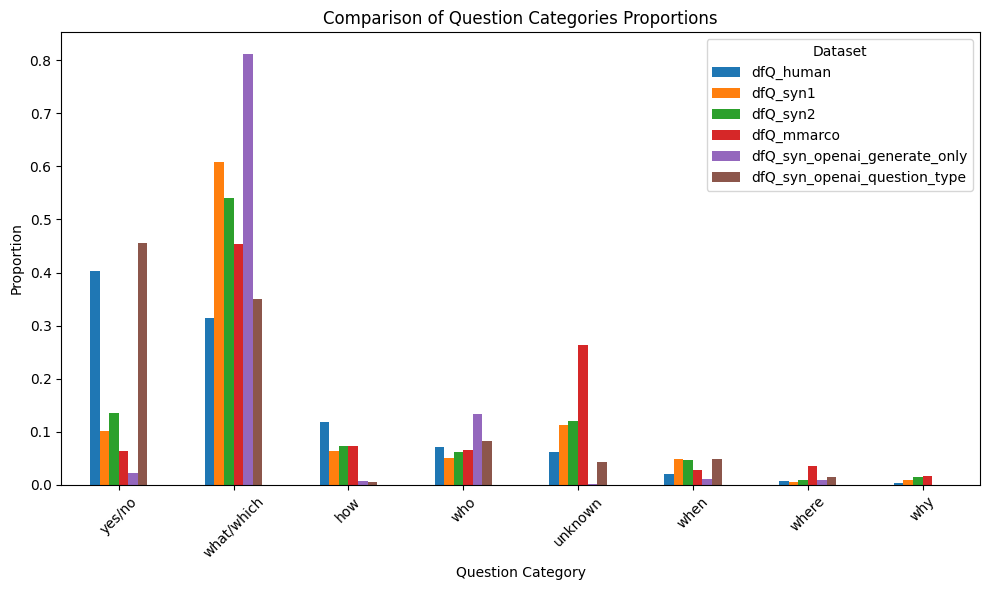

In [180]:
# Combine Series into a DataFrame
df = pd.concat([dfQ_human_questions_cat, dfQ_syn1_questions_cat, dfQ_syn2_questions_cat, dfQ_mmarco_questions_cat, dfQ_syn_openai_generate_only_cat,dfQ_syn_openai_question_type_cat],
               axis=1)
df.columns = ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco', 'dfQ_syn_openai_generate_only', 'dfQ_syn_openai_question_type']

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Question Categories Proportions')
plt.xlabel('Question Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('Comparison of Question Categories Proportions.pdf')
plt.show()

After applying rule based classification, we have found that nearly 40% human legal questions are yes/no questions while most synthetic questions are what/which questions (>50%) and only 10% yes/no question. Similar observation goes to MS MARCO human queries.

### Analysis 6: Sentence Complexity

In [50]:
# Function to count POS tags in a dataset
def count_dependencies(series):
    dep_counts = {}
    for question in series:
        doc = nlp(question)
        for token in doc:
            dep = token.dep_
            dep_counts[dep] = dep_counts.get(dep, 0) + 1
    total_deps = sum(dep_counts.values())
    # Normalize counts to get density
    dep_counts = {dep: count / total_deps for dep, count in dep_counts.items()}
    return dep_counts

In [51]:
dfQ_human_dep_dist = count_dependencies(dfQ_human["question"])
dfQ_syn1_dep_dist = count_dependencies(dfQ_syn1["text"])
dfQ_syn2_dep_dist = count_dependencies(dfQ_syn2["question"].sample(10000))
dfQ_mmarco_dep_dist = count_dependencies(dfQ_mmarco["question"].sample(10000))

In [181]:
dfQ_syn_openai_generate_only_dep_dist  = count_dependencies(dfQ_syn_openai_generate_only["synthetic_question"].sample(5000))
dfQ_syn_openai_question_type_dep_dist  = count_dependencies(dfQ_syn_openai_question_type["synthetic_question"].sample(5000))

In [182]:
dep_counts_datasets = [dfQ_human_dep_dist, dfQ_syn1_dep_dist, dfQ_syn2_dep_dist, dfQ_mmarco_dep_dist, dfQ_syn_openai_generate_only_dep_dist,dfQ_syn_openai_question_type_dep_dist]
# Convert to DataFrame for easier plotting
df_deps = pd.DataFrame(dep_counts_datasets).T
df_deps.columns = ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco', 'dfQ_syn_openai_generate_only', 'dfQ_syn_openai_question_type']
df_deps = df_deps.fillna(0)  # Fill missing values with 0
df_deps

,dfQ_human,dfQ_syn1,dfQ_syn2,dfQ_mmarco,dfQ_syn_openai_generate_only,dfQ_syn_openai_question_type
nsubj,0.080875,0.055868,0.056870,0.051247,0.046586,0.045687
cop,0.014260,0.016844,0.016355,0.016468,0.003431,0.004699
ROOT,0.092304,0.105752,0.108354,0.139652,0.039838,0.046042
obl:mod,0.023063,0.017668,0.019743,0.020504,0.037612,0.031495
punct,0.106255,0.012892,0.012163,0.016617,0.050688,0.049944
cc,0.018378,0.008050,0.006097,0.007549,0.019588,0.018749
mark,0.030579,0.026208,0.028064,0.027816,0.024627,0.041793
xcomp,0.023269,0.014153,0.019156,0.013939,0.018238,0.025019
det,0.117014,0.171474,0.164514,0.144573,0.169456,0.161400
obj,0.054208,0.027535,0.034326,0.037183,0.021898,0.029347


In [183]:
df_deps_subset = df_deps.T[["cc","xcomp", "parataxis", "advcl", "ccomp", "conj"]].T

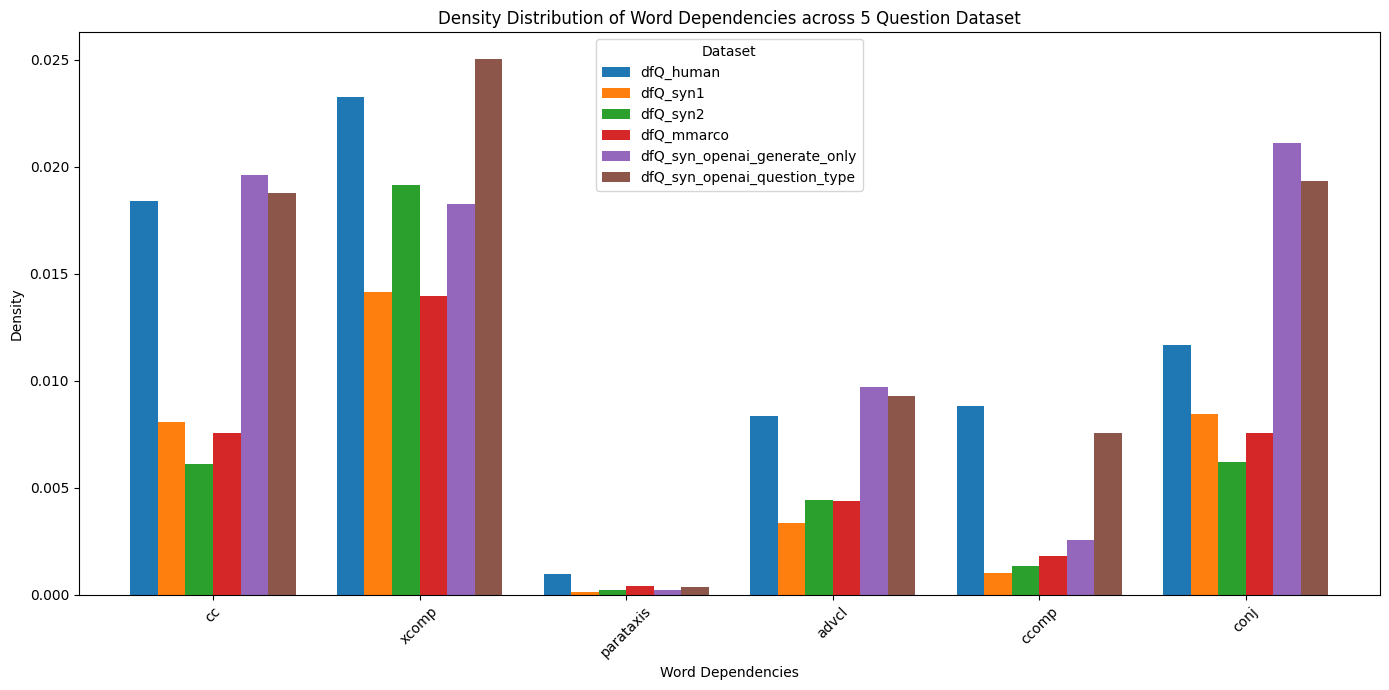

In [184]:
# Plot the density distribution of POS tags
df_deps_subset.plot(kind='bar', figsize=(14, 7), width=0.8)
plt.title('Density Distribution of Word Dependencies across 5 Question Dataset')
plt.xlabel('Word Dependencies')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('Density Distribution of Word Dependencies Across Datasets.pdf')
plt.show()

When evaluating sentence complexities, it is common to check the number of subordinate clauses and the use of compound and complex sentences.
* subordinate clauses: xcomp(Open Clausal Complement), ccomp(Clausal Complement), advcl (Adverbial Clause Modifier)
* compound and complex sentences: cc(Coordinating Conjunction), conj(Conjunct), parataxis (Paratactic Relation)

Based on these 6 indicators, legal human questions might be considered the most complex due to the higher use of subordinate clauses and compound sentences.

### Analysis 7: Sentence Vocabulary

In [149]:
from collections import Counter

def tokenize_lemma(sentence):
    doc = nlp(sentence)
    return [token.lemma_.lower() for token in doc if token.is_alpha]

dfQ_human_unique_words = len(set(dfQ_human["question"].progress_apply(tokenize_lemma).explode()))
dfQ_syn1_unique_words = len(set(dfQ_syn1["text"].sample(1108).progress_apply(tokenize_lemma).explode()))
dfQ_mmarco_unique_words = len(set(dfQ_mmarco["question"].sample(1108).progress_apply(tokenize_lemma).explode()))

Processing text: 100%|██████████| 1108/1108 [00:04<00:00, 260.30it/s]


In [129]:
dfQ_mmarco_unique_words

2549

In [185]:
dfQ_human_counter = Counter(dfQ_human["question"].progress_apply(tokenize_lemma).explode())
dfQ_syn1_counter = Counter(dfQ_syn1["text"].sample(1108).progress_apply(tokenize_lemma).explode())
dfQ_mmarco_counter = Counter(dfQ_mmarco["question"].sample(1108).progress_apply(tokenize_lemma).explode())
dfQ_syn_openai_generate_only_counter = Counter(dfQ_syn_openai_generate_only["synthetic_question"].sample(1108).progress_apply(tokenize_lemma).explode())
dfQ_syn_openai_question_type_counter = Counter(dfQ_syn_openai_question_type["synthetic_question"].sample(1108).progress_apply(tokenize_lemma).explode())

data = {
    'Word': [],
    'Count': [],
    'Dataset': []
}

# Convert Counter objects to DataFrame
data = []
for label, counter in zip(["dfQ_human", "dfQ_syn1", "dfQ_mmarco", "dfQ_syn_openai_generate_only", "dfQ_syn_openai_question_type"], [dfQ_human_counter, dfQ_syn1_counter, dfQ_mmarco_counter,dfQ_syn_openai_generate_only_counter, dfQ_syn_openai_question_type_counter]):
    for word, count in counter.items():
        data.append({"Word": word, "Count": count, "Dataset": label})
df_word_count = pd.DataFrame(data)

Processing text: 100%|██████████| 1108/1108 [00:04<00:00, 271.18it/s]


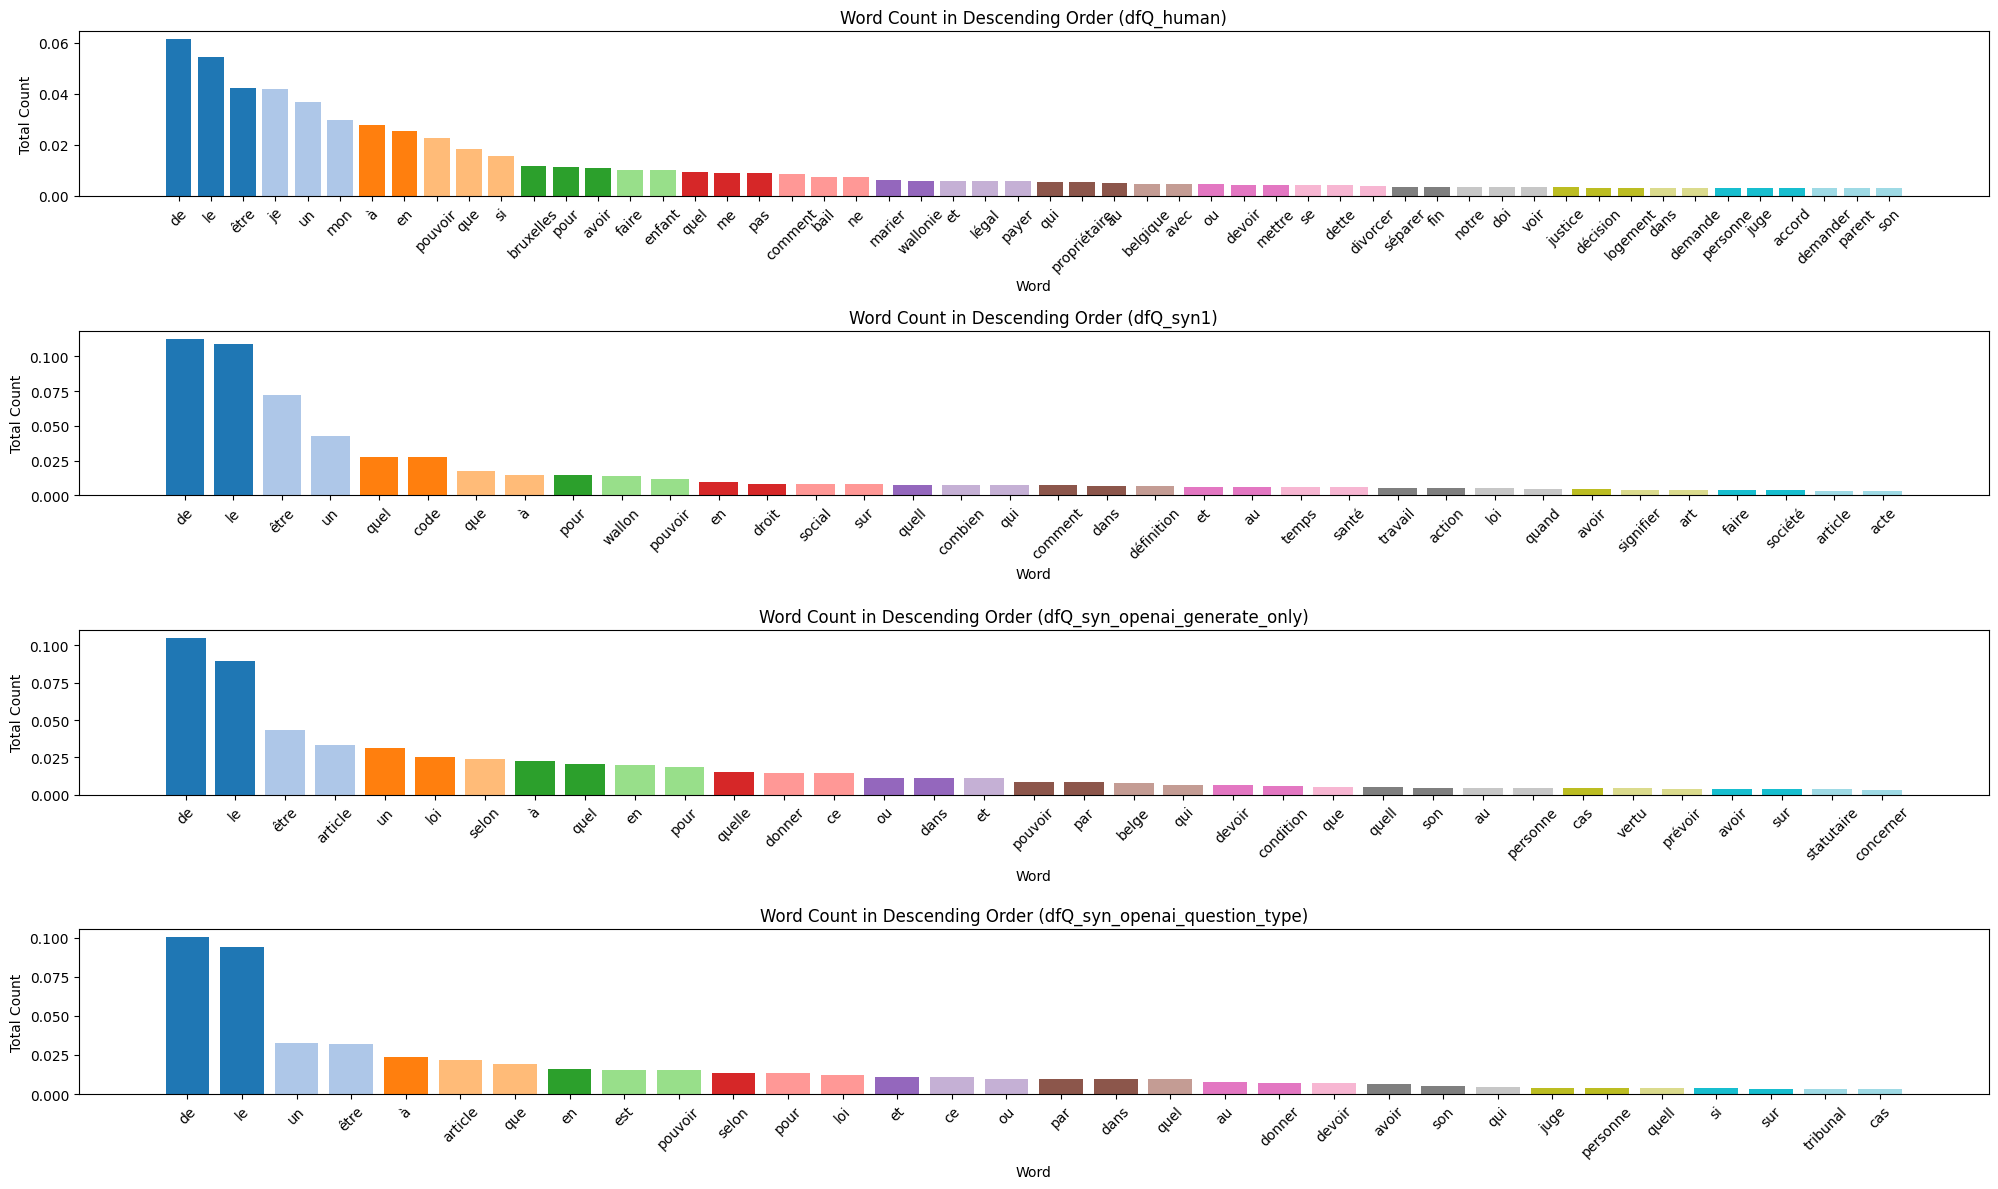

In [252]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_word_count(df_word_count, title=None, ax=None):
    data_sorted = df_word_count.sort_values(by='Count', ascending=False)
    total_count = data_sorted['Count'].sum()
    data_sorted['Proportion'] = data_sorted['Count'] / total_count
    data_sorted = data_sorted[data_sorted['Proportion'] > .003]
    colors = plt.cm.tab20(np.linspace(0, 1, len(data_sorted)))
    
    if ax is None:
        ax = plt.gca()
    
    ax.bar(data_sorted['Word'], data_sorted['Proportion'], color=colors)
    ax.set_title(f'Word Count in Descending Order ({title})')
    ax.set_xlabel('Word')
    ax.set_ylabel('Total Count')
    ax.tick_params(axis='x', rotation=45)
    ax.figure.tight_layout()

# Adjusted for a vertical stack of subplots:
fig, axs = plt.subplots(4, 1, figsize=(20, 12))  # 4 rows, 1 column for vertical stacking

# Assuming you have four DataFrame objects: df1, df2, df3, df4
visualize_word_count(df_word_count[(df_word_count['Dataset'] == "dfQ_human")], ax=axs[0], title="dfQ_human")
visualize_word_count(df_word_count[(df_word_count['Dataset'] == "dfQ_syn1")], ax=axs[1], title="dfQ_syn1")
visualize_word_count(df_word_count[(df_word_count['Dataset'] == "dfQ_syn_openai_generate_only")], ax=axs[2], title="dfQ_syn_openai_generate_only")
visualize_word_count(df_word_count[(df_word_count['Dataset'] == "dfQ_syn_openai_question_type")], ax=axs[3], title="dfQ_syn_openai_question_type")
plt.show()